## Imorting Necessary Libraries


In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn import metrics
from joblib import dump

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Loading Dataset

In [ ]:
Ravdess = "/home/abhi/Documents/GitHub/Speech_Emotion_Recognition/dataset/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(Ravdess)

## Finding File correspoding to its Emotion and Creating a DataFrame

In [ ]:
#ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    #print(actor,"->actor")
    for file in actor:
        part = file.split('.')
        #print(file,"->file")
        #print(part,"-1st split")
        part = part[0].split('-')
        #print(part,"-2nd split")
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

    #print(file_emotion);print(file_path)

In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df],axis=1)

# changing integers to actual emotions.
Ravdess_df['Emotions'].replace([1,2,3,4,5,6,7,8],['neutral','calm','happy','sad','angry','fear','disgust','surprise'], inplace=True)
Ravdess_df.head(10)

,Emotions,Path
0,calm,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
1,sad,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
2,angry,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
3,disgust,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
4,calm,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
5,angry,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
6,happy,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
7,angry,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
8,happy,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...
9,surprise,/home/abhi/Documents/GitHub/Speech_Emotion_Rec...


## Preprocessing

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=int(pitch_factor))

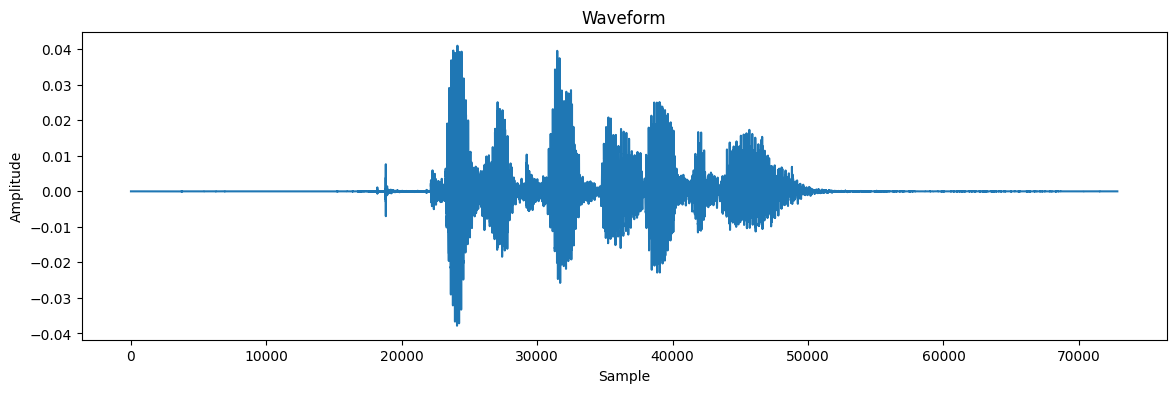

In [ ]:
#1.Actual Audio
path = '/home/abhi/Documents/GitHub/Speech_Emotion_Recognition//dataset/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'
data, sample_rate = librosa.load(path)

# Plot waveform
plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

#Audio preview
Audio(path)

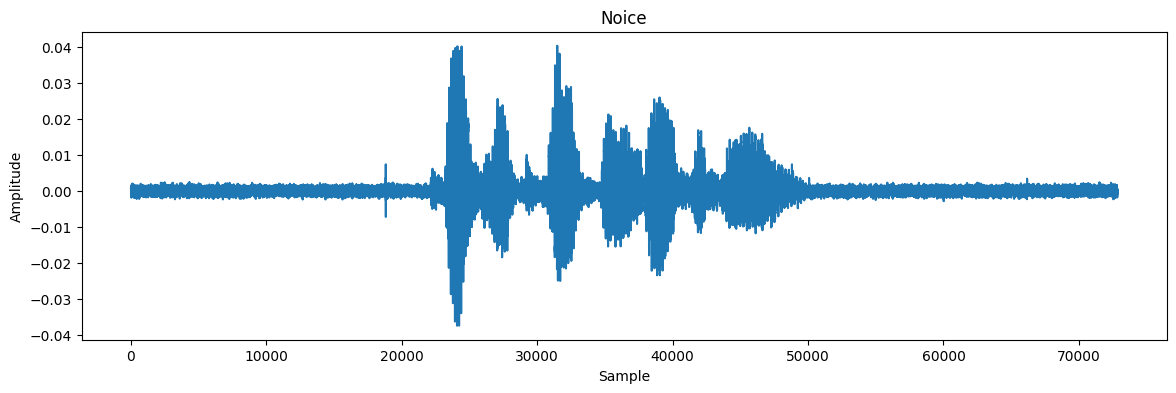

In [ ]:
#2Noise injection
data, sample_rate = librosa.load(path)
x = noise(data)

# Plot waveform
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Noice')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

#Audio preview
Audio(path)

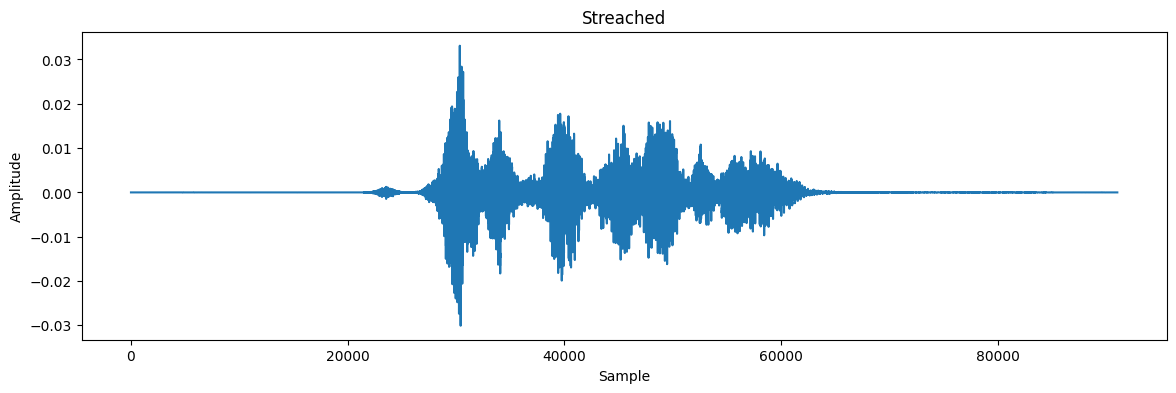

In [ ]:
#3.Streatching
x = stretch(data)
data, sample_rate = librosa.load(path)

# Plot waveform
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Streached')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

#Audio preview
Audio(path)

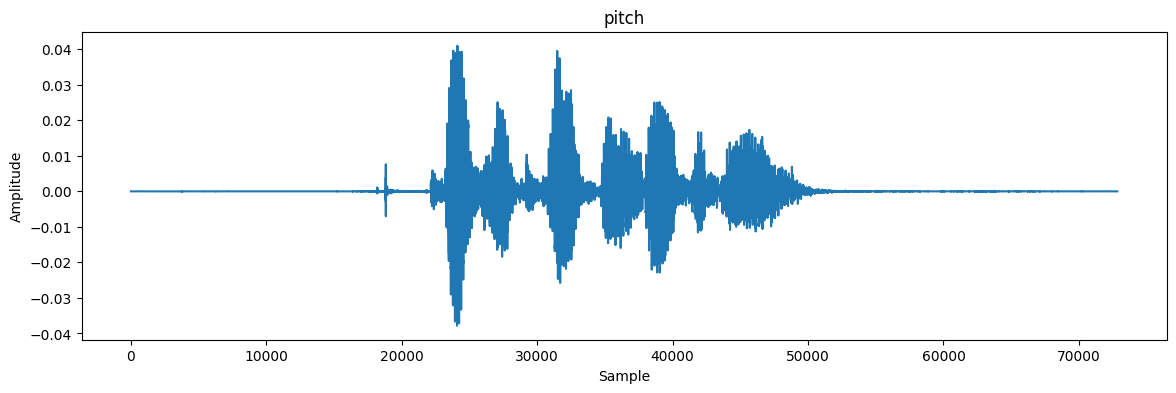

In [ ]:
#4.Pitch
x = pitch(data, sample_rate)
data, sample_rate = librosa.load(path)

# Plot waveform
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('pitch')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

#Audio preview
Audio(path)

In [ ]:
def extract_features(data, sample_rate):
    result = np.array([])  # Initialize result as an empty array
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    #contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    result = np.hstack((result, contrast))


    return result

In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch,sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    #print(path)


In [ ]:
Features = pd.DataFrame(X)
Features['Emotions'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,Emotions
0,-589.414246,81.973198,12.343596,25.607128,16.602669,-11.949897,-14.370031,-6.983633,6.587001,-10.379439,...,0.737936,0.666490,22.554266,16.029303,17.869554,16.799206,18.616788,16.601068,45.544870,calm
1,-528.984100,62.672789,17.076924,21.051319,14.090295,-9.039869,-13.991257,-5.064468,3.328533,-8.202642,...,0.750045,0.691148,21.083424,16.001704,17.956368,15.890187,17.298942,14.969459,15.189545,calm
2,-619.733459,79.295952,12.588869,25.710716,16.154430,-12.746095,-15.844067,-7.068908,7.006809,-10.950516,...,0.712696,0.720794,23.558359,15.961113,18.399595,18.058618,19.655571,17.590128,45.810326,calm
3,-526.753845,92.580917,-10.781020,16.255447,13.311153,-24.835682,-21.753345,-9.959447,-24.178549,-10.386139,...,0.594964,0.587124,24.551826,14.446533,18.286435,16.439009,18.415831,21.058631,45.520110,sad
4,-477.143510,64.168382,-0.282612,15.181931,8.501599,-20.219499,-19.597352,-10.811278,-18.705892,-12.427767,...,0.640532,0.623584,21.649236,14.135893,18.134219,16.119149,16.960797,17.916775,14.752379,sad


In [ ]:
#Encoding output vector

encoder = OneHotEncoder()

Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
X = Features.drop('Emotions',axis=1).values
Y = Features['Emotions'].values

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 169), (3240,), (1080, 169), (1080,))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 169), (3240,), (1080, 169), (1080,))

## Training,Predition

In [ ]:
#Random Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

# Predict and evaluate
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.7722


In [ ]:
#Generating Classification Report
accuracy = metrics.accuracy_score(y_test,y_pred)
report = metrics.classification_report(y_test, y_pred)  # Generating classification report
print(f"The Accuracy Score With Linear Kernel is: {accuracy}")
print(f"The classification Report: \n{report}")

The Accuracy Score With Linear Kernel is: 0.7722222222222223
The classification Report: 
              precision    recall  f1-score   support

       angry       0.92      0.84      0.88       144
        calm       0.68      0.95      0.79       144
     disgust       0.73      0.77      0.75       144
        fear       0.86      0.82      0.84       144
       happy       0.81      0.69      0.74       144
     neutral       0.73      0.60      0.66        72
         sad       0.68      0.64      0.66       144
    surprise       0.80      0.78      0.79       144

    accuracy                           0.77      1080
   macro avg       0.78      0.76      0.76      1080
weighted avg       0.78      0.77      0.77      1080



In [ ]:
#Prediton on test data
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred
df['Actual Labels'] = y_test

df.head(10)

,Predicted Labels,Actual Labels
0,calm,calm
1,angry,angry
2,angry,angry
3,calm,calm
4,calm,calm
5,surprise,surprise
6,calm,calm
7,fear,fear
8,happy,happy
9,fear,fear


## Saving the model

In [ ]:
#saving file as .pkl file
with open('sound_emotion.pkl', 'wb') as f:  # open a text file
    pickle.dump(model, f) # serialize the list

f.close()

## UI and Implimentation

In [ ]:
# Open the following Drive link(.py file):

https://drive.google.com/file/d/1y1t4-wOspbEQiIhFqn-MosuTbo8VTFKS/view?usp=drive_link